# Metrics and Features - Solution

In this exercise, we want to create a second label feature set. The seeded label feature set
is looking at whether a failure happens the next day. We want to evaluate the performance of the
model with a prediction farther into the future. In order to do this, we will look at whether a failure
occurs in the next week. 

To implement this, you need to do the following:
1. Define a new compound metric `WillFailNextWeek` on top of the simple metric `HasFailureEvent`.
2. Define a new feature `willFailNextWeek` on top of the compound metric.
3. Define a new feature set `labelFeatureSet2` that includes `willFailNextWeek` and has an `HOUR` interval.
4. Materialize the new feature set.
5. Use `evalFeatureSetBatch` to retrieve the materialized feature data.

### Setup

In [1]:
assert len(c3.WindTurbine.eval())>0, "You need to run the 1-Generate-Demo-Data.ipynb notebook first!"

In [2]:
c3.Pkg.setDevMode(True) # needed to add compound metric

## Review the data

Let's pick a specific subject that we'll view.

In [3]:
SUBJECT_FILTER='id=="demo_TURBINE-3"'

Review the raw data from WindTurbineEvent.

In [4]:
c3.WindTurbineEvent.eval(limit=10)

id  ... eventCode
0  00af1cc0-da52-4d2c-8d42-8d061131d1ed  ...        f2
1  015ef5e2-1722-4633-a3cd-8da83853999e  ...        m1
2  03ff2f28-0f29-4478-8f35-9f662493bcf4  ...        m5
3  04cf2c34-012c-4dc9-a0af-6a6b30c84f8f  ...        f2
4  054c30e7-482e-478a-93ed-48f2f79a569d  ...        m4
5  05541efc-780f-4354-9bf2-0052590d1c3a  ...        f1
6  05e562e6-fe72-4278-8186-4144beb0b099  ...        f1
7  06ddb413-88a2-403d-bc45-4648d56384ee  ...        m5
8  0769ea5c-7be3-4246-89e5-a6ce849c2fa7  ...        m5
9  07aa918d-e8be-4c82-8580-3fd1883671a5  ...        f1

[10 rows x 5 columns]

Now, we look at the underlying simple metric.

In [5]:
c3.WindTurbine.eval(projection='HasFailureEvent', filter=SUBJECT_FILTER)

subject  timestamp  HasFailureEvent
0    demo_TURBINE-3 2022-05-09              0.0
1    demo_TURBINE-3 2022-05-10              1.0
2    demo_TURBINE-3 2022-05-11              0.0
3    demo_TURBINE-3 2022-05-12              0.0
4    demo_TURBINE-3 2022-05-13              0.0
..              ...        ...              ...
361  demo_TURBINE-3 2023-05-05              0.0
362  demo_TURBINE-3 2023-05-06              0.0
363  demo_TURBINE-3 2023-05-07              0.0
364  demo_TURBINE-3 2023-05-08              0.0
365  demo_TURBINE-3 2023-05-09              0.0

[366 rows x 3 columns]

## Exercise step 1

<div class="alert-info">
    <b>Exercise</b>: Define a new compound metric called <code>WillFailNextWeek</code> that looks at <code>HasFailureEvent</code>
over 168 hours (one week). It should return true if <code>HasFailureEvent</code> is true over that time range,
and false otherwise.
</div>


In [6]:
cm = c3.CompoundMetric(
    name="WillFailNextWeek",
    id="WillFailNextWeek",
    expression="window('MAX', HasFailureEvent, 0, 168) > 0"
).upsert()
cm

{
  "type" : "CompoundMetric",
  "name" : "WillFailNextWeek",
  "expression" : "window('MAX', HasFailureEvent, 0, 168) > 0",
  "id" : "WillFailNextWeek"
}

In [7]:
c3.WindTurbine.eval(projection='WillFailNextWeek', filter=SUBJECT_FILTER)

subject  timestamp  WillFailNextWeek
0    demo_TURBINE-3 2022-05-09               1.0
1    demo_TURBINE-3 2022-05-10               1.0
2    demo_TURBINE-3 2022-05-11               1.0
3    demo_TURBINE-3 2022-05-12               1.0
4    demo_TURBINE-3 2022-05-13               1.0
..              ...        ...               ...
361  demo_TURBINE-3 2023-05-05               0.0
362  demo_TURBINE-3 2023-05-06               0.0
363  demo_TURBINE-3 2023-05-07               0.0
364  demo_TURBINE-3 2023-05-08               0.0
365  demo_TURBINE-3 2023-05-09               0.0

[366 rows x 3 columns]

## Excercise step 2

<div class="alert-info">
    <b>Exercise</b>: Now, create a feature named <code>willFailNextWeek</code> from the <code>WillFailNextWeek</code> metric,
with an interval of <code>HOUR</code>.
</div>

In [8]:
feature = c3.Feature.fromMetric(
    subjectType=c3.WindTurbine, 
    legacy=c3.LegacyMetric(metric="WillFailNextWeek", interval='HOUR'), 
    name="willFailNextWeek"
).merge().get()
feature

{
  "type" : "Feature",
  "id" : "WindTurbine#willFailNextWeek",
  "name" : "willFailNextWeek",
  "meta" : {
    "appCode" : 1765444691422056025,
    "env" : "c3",
    "app" : "wt46",
    "created" : "2023-05-09T19:23:27Z",
    "createdBy" : "BA",
    "updated" : "2023-05-09T19:23:27Z",
    "updatedBy" : "BA",
    "timestamp" : "2023-05-09T19:23:27Z",
    "fetchInclude" : "[]",
    "fetchType" : "Feature"
  },
  "version" : 1,
  "subjectType" : "WindTurbine",
  "_data" : {
    "type" : "Data.Lazy",
    "lazies" : {
      "0" : {
        "type" : "Data.Lazy",
        "this" : "WindTurbine",
        "action" : "eval",
        "args" : {
          "spec" : {
            "type" : "EvalSpec",
            "projection" : "WillFailNextWeek",
            "interval" : "HOUR",
            "timeZone" : {
              "name" : "NONE"
            },
            "materialize" : true
          }
        }
      }
    }
  }
}

If we evaluate this feature, we won't see any data, since we haven't materialized it.

In [9]:
c3.WindTurbine.eval(projection='willFailNextWeek', filter=SUBJECT_FILTER)

Empty DataFrame
Columns: []
Index: []

## Exercise Step 3

<div class="alert-info">
    <b>Exercise</b>: Now, create a feature set named <code>labelFeatureSet2</code> which
includes one feature <code>willFailNextWeek</code>.
</div>

In [10]:
feature_set = c3.Feature.Set(
    id='WindTurbine#labelFeatureSet2',
    name='labelFeatureSet2',
    subjectType=c3.WindTurbine,
    interval='HOUR',
    features=['willFailNextWeek']).merge().get()
feature_set

{
  "type" : "Feature.Set",
  "id" : "WindTurbine#labelFeatureSet2",
  "name" : "labelFeatureSet2",
  "meta" : {
    "appCode" : 1765444691422056025,
    "env" : "c3",
    "app" : "wt46",
    "created" : "2023-05-09T19:23:30Z",
    "createdBy" : "BA",
    "updated" : "2023-05-09T19:23:30Z",
    "updatedBy" : "BA",
    "timestamp" : "2023-05-09T19:23:30Z",
    "fetchInclude" : "[]",
    "fetchType" : "Feature.Set"
  },
  "version" : 1,
  "subjectType" : "WindTurbine",
  "interval" : "HOUR",
  "features" : [ "willFailNextWeek" ]
}

## Exercise Step 4

<div class="alert-info">
    <b>Exercise</b>: Now, materialize the feature set.
</div>

In [11]:
feature_set.materialize(sync=True)

## Exercise Step 5

<div class="alert-info">
    <b>Exercise</b>: Now, materialize the feature set.
</div>


In [12]:
eval_fs_result = c3.WindTurbine.evalFeatureSetBatch(featureSet=feature_set, filter=SUBJECT_FILTER,
                                                   start='2021-01-01', end='2023-01-01')
eval_fs_result.head(10)

subject           timestamp  willFailNextWeek
0  demo_TURBINE-3 2021-01-01 00:00:00               0.0
1  demo_TURBINE-3 2021-01-01 01:00:00               0.0
2  demo_TURBINE-3 2021-01-01 02:00:00               0.0
3  demo_TURBINE-3 2021-01-01 03:00:00               0.0
4  demo_TURBINE-3 2021-01-01 04:00:00               0.0
5  demo_TURBINE-3 2021-01-01 05:00:00               0.0
6  demo_TURBINE-3 2021-01-01 06:00:00               0.0
7  demo_TURBINE-3 2021-01-01 07:00:00               0.0
8  demo_TURBINE-3 2021-01-01 08:00:00               0.0
9  demo_TURBINE-3 2021-01-01 09:00:00               0.0

We can use `matplotlib` to visualize the results of our evaluation.

/c3/platform/src/data/DataImpl.Pandas.py:438: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  return pd.DataFrame(values, columns=columns).astype(types, errors='ignore')


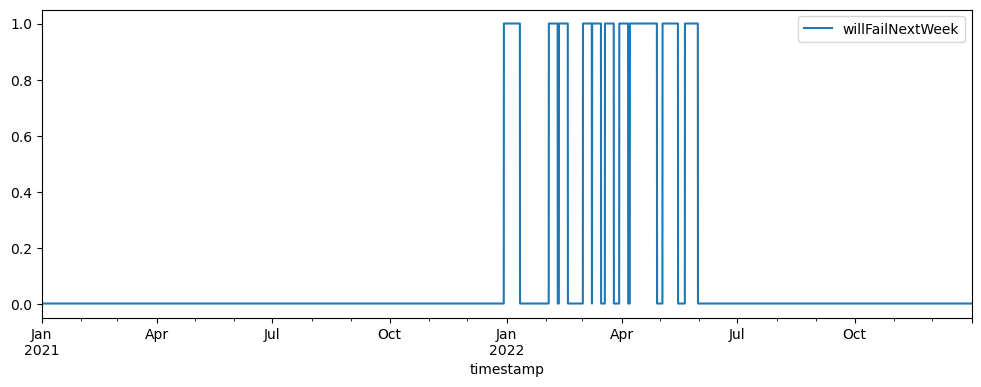

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(12,4))
plot_df = eval_fs_result.to_pandas()
for col in ['willFailNextWeek']:
    plot_df.plot(x='timestamp', y=col, ax = ax)